In [383]:
import importlib
import Blackjack_simulator as bjck
importlib.reload(bjck)


<module 'Blackjack_simulator' from 'c:\\Users\\chuck\\Desktop\\ds543\\git\\BlackJack-RL-DQN\\Blackjack_simulator.py'>

In [384]:
import Blackjack_simulator as bjck
from Blackjack_simulator import deal
from Blackjack_simulator import draw
import gymnasium as gym
from typing import Optional, Tuple, Union
from gymnasium import logger, spaces

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [385]:
class BlackJackEnv(gym.Env):
    def __init__(self):
        super(BlackJackEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(2)  # Hit or Stand
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 1]), high=np.array([21, 4, 11]), dtype=np.float32)
        self.reset()  # Initialize variables properly

    def reset(self, *, seed: Optional[int] = 42, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.score, self.hand = deal()  # Ensure 'deal' function works properly
        self.aces = sum(1 for card in self.hand if card == 11)
        self.open_card = draw()  # Ensure 'draw' function works properly
        obs = np.array([self.score, self.aces, self.open_card], dtype=np.float32)
        return obs, {}  # info dictionary is empty

    def rewardfnc(self, score):
        if score > 21:
            return -1
        else:
            dealers_total = bjck.dealer_from_hand(self.open_card)  # Make sure 'bjck' is defined
            if score > dealers_total:
                return 1
            elif score < dealers_total:
                return -1
            else:
                return 0

    def step(self, action):
        if action == 0:  # Stand
            reward = self.rewardfnc(self.score)
            return np.array([self.score, self.aces, self.open_card]), reward, True, False, {}  # Done is True on Stand

        card = draw()  # Ensure 'draw' is a defined function
        self.score += card
        if card == 11:
            self.aces += 1

        while self.score > 21 and self.aces > 0:
            self.score -= 10
            self.aces -= 1

        terminated = self.score > 21
        reward = -1 if terminated else 0
        return np.array([self.score, self.aces, self.open_card]), reward, terminated, False, {}


In [386]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [387]:

env = BlackJackEnv()
num_episodes = 10000
total_reward = 0

for _ in range(1000):
    state = env.reset()
    terminated = False
    episode_reward = 0
    
    while not terminated:
        action = env.action_space.sample()  # Choose random action (Hit or Stand)
        next_state, reward, terminated,_ , _ = env.step(action)
        episode_reward += reward
    
    total_reward += episode_reward

average_reward = total_reward / num_episodes

print(f"Average Reward over {num_episodes} episodes: {average_reward:.4f}")

Average Reward over 10000 episodes: -0.0422


In [388]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [389]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.001
LR = 1e-4
seed = 5201
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset(seed=seed)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []




In [390]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed


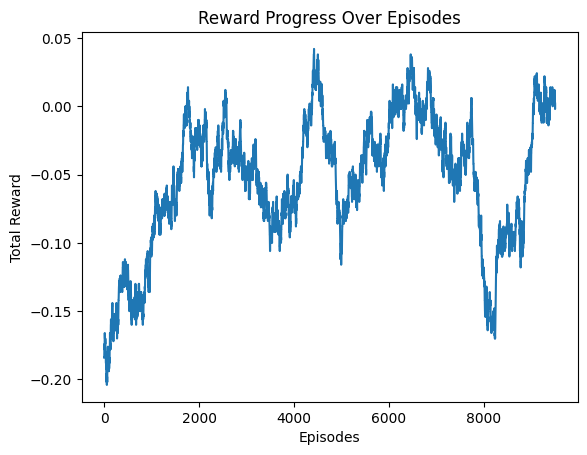

Training Complete, average reward over last 500 episodes: 0.00


In [391]:
import matplotlib.pyplot as plt
import numpy as np

def dqnmod(steps = 10000):
    reward_history = []  

    for i_episode in range(steps):
        state, info = env.reset(seed=seed)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0
        terminated = False
        
        while not terminated:
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Optimize the model
            optimize_model()

            # Update the target network
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_reward += reward.item()
                reward_history.append(episode_reward)
                break

        # Print progress every 1000 episodes
        if i_episode % 1000 == 0:
            print(f'Episode {i_episode+1}: {((i_episode+1)/num_episodes)*100:.2f}% completed')
    return reward_history
def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
smoothed_rewards = moving_average(dqnmod(), 500)
    # Plot the total rewards over episodes
plt.plot(smoothed_rewards)
plt.title('Reward Progress Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

print(f'Training Complete, average reward over last 500 episodes: {smoothed_rewards[-1]:.2f}')


In [392]:
""" def run_agent(env, policy_net, num_episodes=1): #eye test. making sure that the agent runs in a somewhat normal way
    for _ in range(num_episodes):
        state, _ = env.reset(seed=20)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        print("Starting a new episode...\n")
        
        total_reward = 0
        terminated = False
        
        while not terminated:
            score, aces, open_card = state[0][0].item(), state[0][1].item(), state[0][2].item()
            print(f"Agent's score: {score}, Aces: {aces}")
            print(f"Dealer's open card: {int(open_card)}")
            
            action = select_action(state)
            if action.item() == 0:
                print("Action: Stand")
            else:
                print("Action: Hit")
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            
            new_score, new_aces, new_open_card = next_state[0], next_state[1], next_state[2]
            print(f"New score: {new_score}, Aces: {new_aces}")
            print(f"Dealer's open card: {int(new_open_card)}\n")
            
            total_reward += reward
            
            if terminated:
                print(f"Episode terminated. Total reward: {total_reward}")
                break

run_agent(env, policy_net) """

' def run_agent(env, policy_net, num_episodes=1): #eye test. making sure that the agent runs in a somewhat normal way\n    for _ in range(num_episodes):\n        state, _ = env.reset(seed=20)\n        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)\n        \n        print("Starting a new episode...\n")\n        \n        total_reward = 0\n        terminated = False\n        \n        while not terminated:\n            score, aces, open_card = state[0][0].item(), state[0][1].item(), state[0][2].item()\n            print(f"Agent\'s score: {score}, Aces: {aces}")\n            print(f"Dealer\'s open card: {int(open_card)}")\n            \n            action = select_action(state)\n            if action.item() == 0:\n                print("Action: Stand")\n            else:\n                print("Action: Hit")\n            \n            next_state, reward, terminated, truncated, _ = env.step(action.item())\n            \n            state = torch.tensor(next_s

In [393]:
def reset_agent():
    global policy_net, target_net, optimizer, memory, steps_done

    # Reinitialize networks
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    # Reset optimizer
    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

    # Clear replay memory
    memory = ReplayMemory(10000)

    # Reset step counter
    steps_done = 0

    print("Agent has been reset.")

# Call reset_agent() when needed
reset_agent()


Agent has been reset.


In [394]:
class DoubleDQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DoubleDQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [395]:

num_episodes = 10000
reward_history = []
def doubledqn(num_episodes=10000):
    for i_episode in range(num_episodes):
        state, _ = env.reset(seed=seed)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0
        terminated = False
        
        while not terminated:
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            memory.push(state, action, next_state, reward)
            state = next_state
            optimize_model()
            
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)
            
            episode_reward += reward.item()
            if terminated:
                reward_history.append(episode_reward)
                break
        
        if i_episode % 1000 == 0:
            print(f'Episode {i_episode+1}: {((i_episode+1)/num_episodes)*100:.2f}% completed')
    return reward_history

Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed


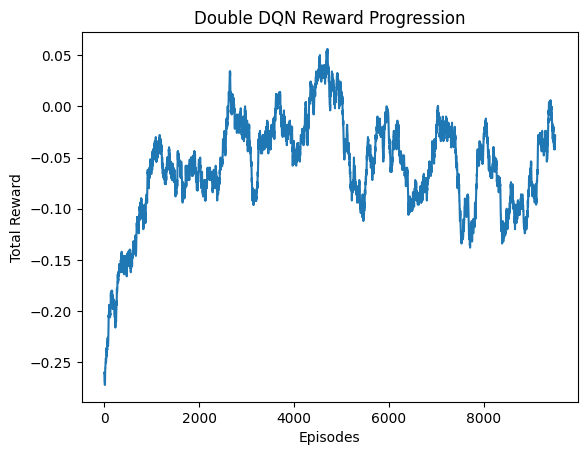

Training Complete, average reward over last 500 episodes: -0.03


In [396]:
import matplotlib.pyplot as plt
smoothed_rewards = np.convolve(doubledqn(), np.ones(500)/500, mode='valid')
plt.plot(smoothed_rewards)
plt.title('Double DQN Reward Progression')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()
print(f'Training Complete, average reward over last 500 episodes: {smoothed_rewards[-1]:.2f}')

In [397]:
""" def run_agent(env, policy_net, num_episodes=1): #eye test. making sure that the agent runs in a somewhat normal way
    for _ in range(num_episodes):
        state, _ = env.reset(seed=20)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        print("Starting a new episode...\n")
        
        total_reward = 0
        terminated = False
        
        while not terminated:
            score, aces, open_card = state[0][0].item(), state[0][1].item(), state[0][2].item()
            print(f"Agent's score: {score}, Aces: {aces}")
            print(f"Dealer's open card: {int(open_card)}")
            
            action = select_action(state)
            if action.item() == 0:
                print("Action: Stand")
            else:
                print("Action: Hit")
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            
            new_score, new_aces, new_open_card = next_state[0], next_state[1], next_state[2]
            print(f"New score: {new_score}, Aces: {new_aces}")
            print(f"Dealer's open card: {int(new_open_card)}\n")
            
            total_reward += reward
            
            if terminated:
                print(f"Episode terminated. Total reward: {total_reward}")
                break

run_agent(env, policy_net) """

' def run_agent(env, policy_net, num_episodes=1): #eye test. making sure that the agent runs in a somewhat normal way\n    for _ in range(num_episodes):\n        state, _ = env.reset(seed=20)\n        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)\n        \n        print("Starting a new episode...\n")\n        \n        total_reward = 0\n        terminated = False\n        \n        while not terminated:\n            score, aces, open_card = state[0][0].item(), state[0][1].item(), state[0][2].item()\n            print(f"Agent\'s score: {score}, Aces: {aces}")\n            print(f"Dealer\'s open card: {int(open_card)}")\n            \n            action = select_action(state)\n            if action.item() == 0:\n                print("Action: Stand")\n            else:\n                print("Action: Hit")\n            \n            next_state, reward, terminated, truncated, _ = env.step(action.item())\n            \n            state = torch.tensor(next_s

In [398]:
reset_agent()


Agent has been reset.


In [399]:
class MultiStepDQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_steps=3, gamma=0.99):
        super(MultiStepDQN, self).__init__()
        self.n_steps = n_steps
        self.gamma = gamma
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [400]:
class MultiStepReplayMemory:
    def __init__(self, capacity, n_steps, gamma):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
        self.n_steps = n_steps
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=n_steps)

    def push(self, *args):
        self.n_step_buffer.append(Transition(*args))
        if len(self.n_step_buffer) == self.n_steps:
            state, action, next_state, reward = self._compute_n_step_return()
            self.memory.append(Transition(state, action, next_state, reward))

    def _compute_n_step_return(self):
        state, action = self.n_step_buffer[0].state, self.n_step_buffer[0].action
        reward = sum(self.gamma ** i * self.n_step_buffer[i].reward for i in range(self.n_steps))
        next_state = self.n_step_buffer[-1].next_state
        return state, action, next_state, reward

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [401]:
def nstep(num_episodes=10000,n_steps = 3):
    multi_step_memory = MultiStepReplayMemory(num_episodes, n_steps, GAMMA)
    figglebottom = [] 
    for i_episode in range(num_episodes):
        state, info = env.reset(seed=seed)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0
        terminated = False
        
        while not terminated:
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            multi_step_memory.push(state, action, next_state, reward)

            state = next_state

            optimize_model()

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_reward += reward.item()
                figglebottom.append(episode_reward)
                break

        if i_episode % 1000 == 0:
            print(f'Episode {i_episode+1}: {((i_episode+1)/num_episodes)*100:.2f}% completed')
    return figglebottom


Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed


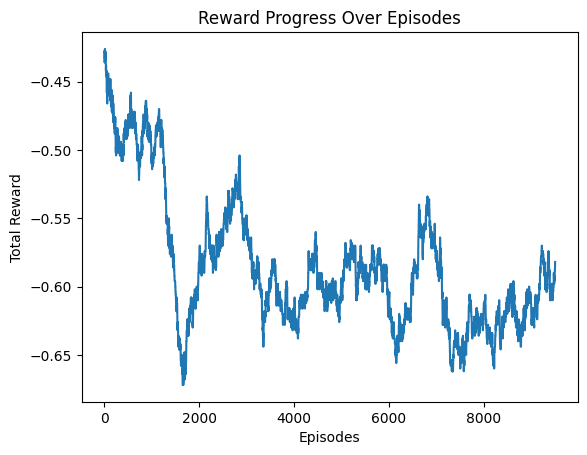

Training Complete, average reward over last 500 episodes: -0.03


In [402]:
plt.plot(moving_average(nstep(), 500))
plt.title('Reward Progress Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

print(f'Training Complete, average reward over last 500 episodes: {smoothed_rewards[-1]:.2f}')


In [403]:
reset_agent()
seed = 5201

Agent has been reset.


In [404]:
#hyperparameter tuning for all training
params = {
    'batch_size': [128, 256, 512],
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'gamma': [0.9, 0.95, 0.99],
    'epsilon_decay': [1000, 5000, 10000],
    'numsteps': [3, 5, 10]
}
n_steps = 500
best_params = None

for batch_size in params['batch_size']:
    for learning_rate in params['learning_rate']:
        for gamma in params['gamma']:
            for epsilon_decay in params['epsilon_decay']:
                    print(f'Training with batch_size: {batch_size}, learning_rate: {learning_rate}, gamma: {gamma}, epsilon_decay: {epsilon_decay}')
                    reset_agent()
                    BATCH_SIZE = batch_size
                    LEARNING_RATE = learning_rate
                    EPSILON_DECAY = epsilon_decay
                    GAMMA = gamma
                    
                    rewards  = dqnmod(n_steps)
                    avg_reward = moving_average(rewards, 100)
                    print(f'Average reward over last 100 episodes: {avg_reward[-1]:.2f}')
                    if best_params is None or avg_reward[-1] > best_params['avg_reward']:
                        best_params = {
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'gamma': gamma,
                            'epsilon_decay': epsilon_decay,
                            'numsteps': n_steps,
                            'avg_reward': avg_reward[-1]
                        }
                        print(f'New best parameters found: {best_params}')
                    

Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000
Agent has been reset.
Episode 1: 0.01% completed
Average reward over last 100 episodes: -0.22
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'numsteps': 500, 'avg_reward': np.float64(-0.22)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 5000
Agent has been reset.
Episode 1: 0.01% completed
Average reward over last 100 episodes: -0.13
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 5000, 'numsteps': 500, 'avg_reward': np.float64(-0.12999999999999998)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 10000
Agent has been reset.
Episode 1: 0.01% completed
Average reward over last 100 episodes: -0.11
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 10000, 'numsteps': 500, 'avg_

{'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.95, 'epsilon_decay': 5000, 'numsteps': 500, 'avg_reward': np.float64(0.06999999999999999)}
Agent has been reset.
Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed
Area under the curve: -573.53


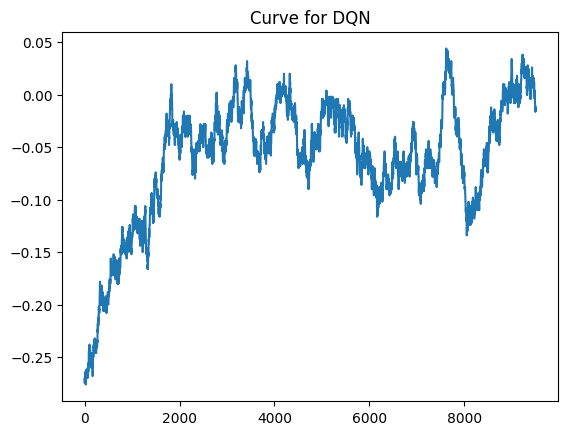

In [405]:
print(best_params)

BATCH_SIZE = best_params['batch_size']

LEARNING_RATE = best_params['learning_rate']

EPSILON_DECAY = best_params['epsilon_decay']

GAMMA = best_params['gamma']
reset_agent()
results = dqnmod(10000)

plt.plot(moving_average(results, 500))
plt.title('Curve for DQN')
print(f'Area under the curve: {np.trapezoid(moving_average(results, 500), dx=1):.2f}')

In [406]:
best_params = None

for batch_size in params['batch_size']:
    for learning_rate in params['learning_rate']:
        for gamma in params['gamma']:
            for epsilon_decay in params['epsilon_decay']:
                    print(f'Training with batch_size: {batch_size}, learning_rate: {learning_rate}, gamma: {gamma}, epsilon_decay: {epsilon_decay}')
                    reset_agent()
                    BATCH_SIZE = batch_size
                    LEARNING_RATE = learning_rate
                    EPSILON_DECAY = epsilon_decay
                    GAMMA = gamma
                    
                    rewards  = doubledqn(n_steps)
                    avg_reward = moving_average(rewards, 100)
                    print(f'Average reward over last 100 episodes: {avg_reward[-1]:.2f}')
                    if best_params is None or avg_reward[-1] > best_params['avg_reward']:
                        best_params = {
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'gamma': gamma,
                            'epsilon_decay': epsilon_decay,
                            'numsteps': n_steps,
                            'avg_reward': avg_reward[-1]
                        }
                        print(f'New best parameters found: {best_params}')
                    

Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.24
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'numsteps': 500, 'avg_reward': np.float64(-0.24)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 5000
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.20
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 5000, 'numsteps': 500, 'avg_reward': np.float64(-0.2)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 10000
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.05
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 10000, 'numsteps': 500, 'avg_reward': np.floa

{'batch_size': 256, 'learning_rate': 1e-05, 'gamma': 0.9, 'epsilon_decay': 5000, 'numsteps': 500, 'avg_reward': np.float64(0.030000000000000006)}
Agent has been reset.
Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed
Area under the curve: -12851.12


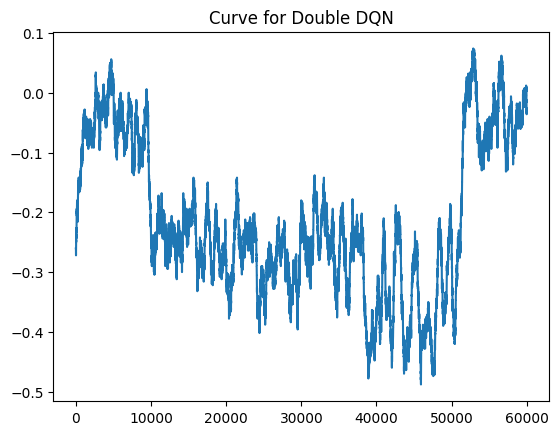

In [407]:
best_params
print(best_params)

BATCH_SIZE = best_params['batch_size']

LEARNING_RATE = best_params['learning_rate']

EPSILON_DECAY = best_params['epsilon_decay']

GAMMA = best_params['gamma']
reset_agent()
results = doubledqn(10000)
plt.plot(moving_average(results, 500))
plt.title('Curve for Double DQN')
print(f'Area under the curve: {np.trapezoid(moving_average(results, 500), dx=1):.2f}')

In [408]:
best_params = None
for batch_size in params['batch_size']:
    for learning_rate in params['learning_rate']:
        for gamma in params['gamma']:
            for epsilon_decay in params['epsilon_decay']:
                for multis in params['numsteps']:
                    print(f'Training with batch_size: {batch_size}, learning_rate: {learning_rate}, gamma: {gamma}, epsilon_decay: {epsilon_decay}, n_steps: {multis}')
                    reset_agent()
                    BATCH_SIZE = batch_size
                    LEARNING_RATE = learning_rate
                    EPSILON_DECAY = epsilon_decay
                    GAMMA = gamma
                    rewards  = nstep(n_steps,multis)
                    avg_reward = moving_average(rewards, 100)
                    print(f'Average reward over last 100 episodes: {avg_reward[-1]:.2f}')
                    if best_params is None or avg_reward[-1] > best_params['avg_reward']:
                        best_params = {
                            'batch_size': batch_size,
                            'learning_rate': learning_rate,
                            'gamma': gamma,
                            'epsilon_decay': epsilon_decay,
                            'DQN steps': multis,
                            'avg_reward': avg_reward[-1]
                        }
                        print(f'New best parameters found: {best_params}')
                    

Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000, n_steps: 3
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.65
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'DQN steps': 3, 'avg_reward': np.float64(-0.6500000000000001)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000, n_steps: 5
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.48
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9, 'epsilon_decay': 1000, 'DQN steps': 5, 'avg_reward': np.float64(-0.4800000000000001)}
Training with batch_size: 128, learning_rate: 0.001, gamma: 0.9, epsilon_decay: 1000, n_steps: 10
Agent has been reset.
Episode 1: 0.20% completed
Average reward over last 100 episodes: -0.20
New best parameters found: {'batch_size': 128, 'learning_rate': 0.001, 'gamma': 0.9,

{'batch_size': 128, 'learning_rate': 1e-05, 'gamma': 0.99, 'epsilon_decay': 5000, 'DQN steps': 5, 'avg_reward': np.float64(0.06999999999999999)}
Agent has been reset.
Episode 1: 0.01% completed
Episode 1001: 10.01% completed
Episode 2001: 20.01% completed
Episode 3001: 30.01% completed
Episode 4001: 40.01% completed
Episode 5001: 50.01% completed
Episode 6001: 60.01% completed
Episode 7001: 70.01% completed
Episode 8001: 80.01% completed
Episode 9001: 90.01% completed
Area under the curve: -1359.59


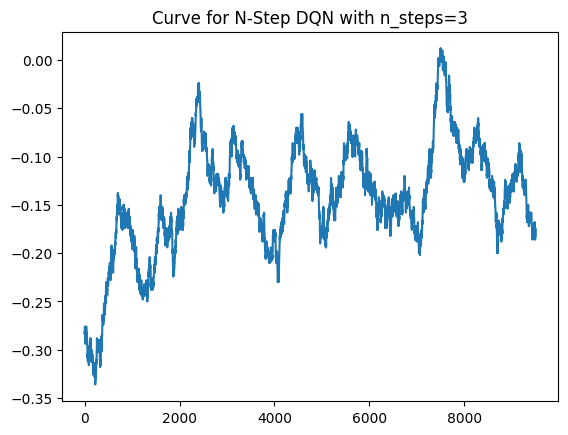

In [409]:

print(best_params)

BATCH_SIZE = best_params['batch_size']

LEARNING_RATE = best_params['learning_rate']

EPSILON_DECAY = best_params['epsilon_decay']

GAMMA = best_params['gamma']
reset_agent()
results = nstep(10000,3)
plt.plot(moving_average(results, 500))
plt.title('Curve for N-Step DQN with n_steps=3')
print(f'Area under the curve: {np.trapezoid(moving_average(results, 500), dx=1):.2f}')

# Q3

In [410]:
from torch.distributions import Categorical

Episode 1, Total Reward: -1
Loss: -0.04817015677690506
Episode 2, Total Reward: -1
Loss: -0.31944555044174194
Episode 3, Total Reward: -1
Loss: -0.051778994500637054
Episode 4, Total Reward: -1
Loss: -0.019669247791171074
Episode 5, Total Reward: -1
Loss: -0.20102758705615997
Episode 6, Total Reward: -1
Loss: -0.10354721546173096
Episode 7, Total Reward: -1
Loss: -0.05200053006410599
Episode 8, Total Reward: -1
Loss: -0.022009853273630142
Episode 9, Total Reward: -1
Loss: -0.4339595437049866
Episode 10, Total Reward: -1
Loss: -0.45414331555366516
Episode 11, Total Reward: -1
Loss: -0.02309294231235981
Episode 12, Total Reward: -1
Loss: -0.10078408569097519
Episode 13, Total Reward: -1
Loss: -0.045360762625932693
Episode 14, Total Reward: -1
Loss: -0.11070363223552704
Episode 15, Total Reward: -1
Loss: -0.03086838312447071
Episode 16, Total Reward: -1
Loss: -0.03894531726837158
Episode 17, Total Reward: -1
Loss: -0.10291986912488937
Episode 18, Total Reward: -1
Loss: -0.2649751901626587

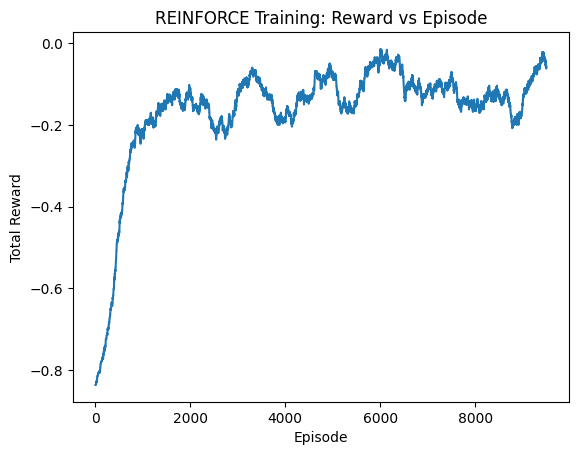

AUC (Total Reward): -1797


In [430]:
import matplotlib.pyplot as plt

class REINFORCE:
    def __init__(self, env, learning_rate=1e-3, discount_factor=0.99):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.model = self.build_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def build_model(self):
        model = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2),  # Two actions: hit or stand
            torch.nn.Softmax(dim=-1)
        )
        return model

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.model(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def update_policy(self, rewards, log_probs):
        discounted_rewards = self.discount_rewards(rewards)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)  
        log_probs = torch.stack(log_probs)

        loss = -torch.sum(log_probs * discounted_rewards)
        
        # Log the loss value
        print(f"Loss: {loss.item()}")

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def discount_rewards(self, rewards):
        discounted = np.zeros_like(rewards, dtype=np.float32)
        cumulative = 0
        for t in reversed(range(len(rewards))):
            cumulative = cumulative * self.discount_factor + rewards[t]
            discounted[t] = cumulative
        return discounted

    def train(self, episodes=1000):
        rewards_per_episode = []  # Track rewards per episode
        total_reward = 0  # Track total reward (AUC)

        for episode in range(episodes):
            state = self.env.reset()[0]
            rewards = []
            log_probs = []
            done = False

            episode_reward = 0
            while not done:
                action, log_prob = self.get_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                state = next_state
                episode_reward += reward

            rewards_per_episode.append(episode_reward)
            total_reward += episode_reward  # Accumulate reward for AUC

            # Log total reward per episode
            print(f"Episode {episode + 1}, Total Reward: {episode_reward}")
            self.update_policy(rewards, log_probs)

        # Return the rewards and total AUC
        return rewards_per_episode, total_reward

    def plot_rewards(self, rewards_per_episode):
        plt.plot(rewards_per_episode)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('REINFORCE Training: Reward vs Episode')
        plt.show()

# Initialize the environment and agent
env = BlackJackEnv()
agent = REINFORCE(env, learning_rate=1e-5, discount_factor=0.99)

# Train the agent and track rewards per episode
rewards_per_episode, total_auc = agent.train(episodes=10000)

# Plot the rewards over episodes
agent.plot_rewards(moving_average(rewards_per_episode,500))

# Calculate AUC (total reward over all episodes)
print(f"AUC (Total Reward): {total_auc}")


In [468]:
import numpy as np
import torch

class TRPO:
    def __init__(self, env, learning_rate=1e-3, discount_factor=0.99, max_kl=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.max_kl = max_kl
        self.policy_model = self.build_model()
        self.optimizer = torch.optim.Adam(self.policy_model.parameters(), lr=learning_rate)

    def build_model(self):
        model = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 2),  # Two actions: hit or stand
            torch.nn.Softmax(dim=-1)
        )
        return model

    def reset(self):
        """
        Resets the agent by reinitializing the policy model and optimizer.
        """
        self.policy_model = self.build_model()  # Rebuild the model
        self.optimizer = torch.optim.Adam(self.policy_model.parameters(), lr=self.learning_rate)  # Reinitialize the optimizer

    def train(self, episodes=1000):
        rewards_per_episode = []
        total_rewards = 0  # Variable to track the total reward for AUC computation
        
        for episode in range(episodes):
            state = self.env.reset()[0]
            rewards = []
            log_probs = []
            old_probs = []
            done = False

            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32)
                action, log_prob = self.get_action(state)
                old_probs.append(torch.log(torch.tensor([self.policy_model(state_tensor)[action].item()])))
                next_state, reward, done, _, _ = self.env.step(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                state = next_state

            rewards_per_episode.append(sum(rewards))
            total_rewards += sum(rewards)  # Accumulate total rewards
            old_probs_tensor = torch.stack(old_probs)
            log_probs_tensor = torch.stack(log_probs)  # Convert log_probs to tensor

            self.update_policy(rewards, log_probs_tensor, old_probs_tensor)

        # Compute AUC as the total rewards across all episodes
        auc = total_rewards
        print(f"AUC (Total Reward Over Episodes): {auc}")
        
        return rewards_per_episode, auc

    def get_action(self, state):
        # Assuming you have a way to get the action from your policy model
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = self.policy_model(state_tensor)
        action = torch.multinomial(action_probs, 1).item()  # Sample action based on policy probabilities
        log_prob = torch.log(action_probs[action])
        return action, log_prob

    def update_policy(self, rewards, log_probs, old_probs):
        discounted_rewards = self.discount_rewards(rewards)
        
        # Ensure that log_probs and discounted_rewards have the same shape and type
        discounted_rewards_tensor = torch.tensor(discounted_rewards, dtype=torch.float32)  # Ensure it's a tensor
        
        # Compute the loss as the negative log-probability times the discounted rewards
        loss = -torch.sum(log_probs * discounted_rewards_tensor)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def discount_rewards(self, rewards):
        discounted = np.zeros_like(rewards, dtype=np.float32)
        cumulative = 0
        for i in reversed(range(len(rewards))):
            cumulative = rewards[i] + self.discount_factor * cumulative
            discounted[i] = cumulative
        return discounted  # Return as a numpy array

    def plot_rewards(self, rewards, window=100):
        """Plot the rewards over episodes with a moving average."""
        rewards = np.array(rewards)

        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.title("Rewards over Episodes (Moving Average)")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.show()

AUC (Total Reward Over Episodes): -989


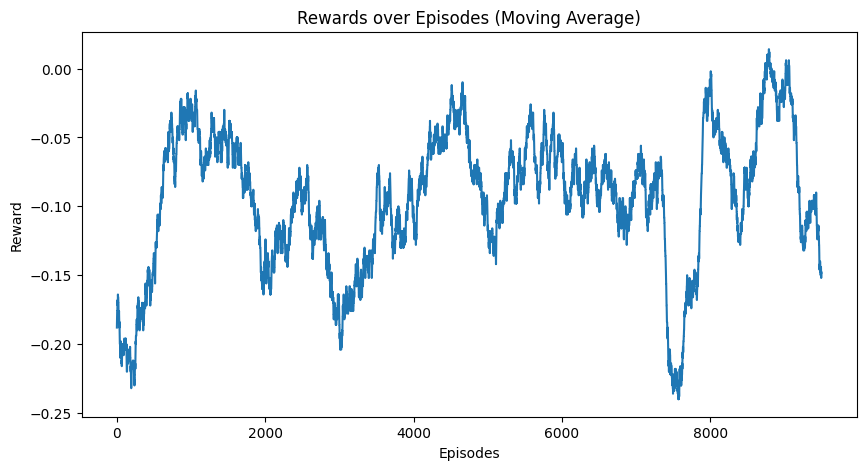

AUC (Total Reward): -989


In [470]:

env = BlackJackEnv()
agent = TRPO(env, learning_rate=1e-3, discount_factor=0.99)
agent.reset()

# Train the agent and track rewards per episode
rewards_per_episode, total_auc = agent.train(episodes=10000)

# Plot the rewards over episodes
agent.plot_rewards(moving_average(rewards_per_episode,500))
print(f"AUC (Total Reward): {total_auc}")


In [487]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PPO:
    def __init__(self, env, learning_rate=1e-3, discount_factor=0.99, clip_param=0.2, epochs=10, batch_size=64):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.clip_param = clip_param
        self.epochs = epochs
        self.batch_size = batch_size
        self.policy_model = self.build_policy_model()
        self.optimizer = optim.Adam(self.policy_model.parameters(), lr=self.learning_rate)
        self.gamma = self.discount_factor

    def build_policy_model(self):
        return nn.Sequential(
            nn.Linear(self.env.observation_space.shape[0], 64), 
            nn.ReLU(),
            nn.Linear(64, 2),  # Two actions: hit or stand
            nn.Softmax(dim=-1)  
        )

    def get_action_log_probs(self, state, action):
        """Compute the log probability of an action given the current policy."""
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.policy_model(state_tensor)
        action_distribution = torch.distributions.Categorical(action_probabilities)
        return action_distribution.log_prob(torch.tensor(action, dtype=torch.int64))

    def select_action(self, state):
        """Select an action based on the current policy."""
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.policy_model(state_tensor)
        action_distribution = torch.distributions.Categorical(action_probabilities)
        action = action_distribution.sample()
        return action.item(), action_distribution.log_prob(action)

    def discount_rewards(self, rewards):
        """Compute discounted rewards."""
        discounted_rewards = []
        cumulative = 0
        for r in reversed(rewards):
            cumulative = r + self.gamma * cumulative
            discounted_rewards.insert(0, cumulative)
        return torch.tensor(discounted_rewards, dtype=torch.float32)

    def update_policy(self, states, actions, old_log_probs, discounted_rewards):
        """Perform PPO policy update."""
        for _ in range(self.epochs):
            current_log_probs = torch.stack([self.get_action_log_probs(s, a) for s, a in zip(states, actions)])

            # Compute ratios safely
            ratios = torch.exp(current_log_probs - old_log_probs.detach())

            # Advantage computation (detach() to avoid modifying tensor)
            advantages = discounted_rewards - discounted_rewards.mean()
            advantages = advantages.detach()

            # Compute loss using PPO clipped objective
            surrogate1 = ratios * advantages
            surrogate2 = torch.clamp(ratios, 1 - self.clip_param, 1 + self.clip_param) * advantages
            loss = -torch.min(surrogate1, surrogate2).mean()

            self.optimizer.zero_grad()
            loss.backward()  # No need for retain_graph=True anymore
            self.optimizer.step()

    def train(self, episodes=10000):
        rewards_per_episode = []
        total_rewards = 0

        for episode in range(episodes):
            state = self.env.reset()[0]
            episode_states, episode_actions, episode_rewards, episode_log_probs = [], [], [], []
            done = False
            total_episode_reward = 0

            while not done:
                action, log_prob = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)

                episode_states.append(state)
                episode_actions.append(action)
                episode_rewards.append(reward)
                episode_log_probs.append(log_prob)

                state = next_state
                total_episode_reward += reward

            rewards_per_episode.append(total_episode_reward)
            total_rewards += total_episode_reward

            discounted_rewards = self.discount_rewards(episode_rewards)
            episode_states_tensor = torch.tensor(np.array(episode_states), dtype=torch.float32)
            episode_actions_tensor = torch.tensor(episode_actions, dtype=torch.int64)
            episode_log_probs_tensor = torch.stack(episode_log_probs)

            self.update_policy(episode_states_tensor, episode_actions_tensor, episode_log_probs_tensor, discounted_rewards)

        auc = total_rewards
        return rewards_per_episode, auc

    def plot_rewards(self, rewards_per_episode, window=100):
        """Plot rewards per episode with moving average."""
        import matplotlib.pyplot as plt
        moving_avg_rewards = np.convolve(rewards_per_episode, np.ones(window) / window, mode='valid')
        plt.plot(moving_avg_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Moving Average of Reward')
        plt.title('PPO Training Rewards')
        plt.show()


C:\Users\chuck\AppData\Local\Temp\ipykernel_20632\4171942089.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
C:\Users\chuck\AppData\Local\Temp\ipykernel_20632\4171942089.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return action_distribution.log_prob(torch.tensor(action, dtype=torch.int64))


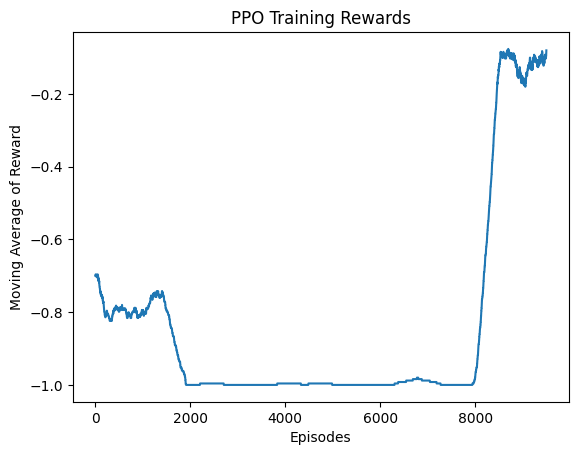

AUC (Total Reward): -8206


In [488]:
# Create the PPO agent
agent = PPO(env, learning_rate=1e-3, discount_factor=0.99, clip_param=0.2)

# Train the agent and track rewards per episode
rewards_per_episode, total_auc = agent.train(episodes=10000)

# Plot the rewards over episodes
agent.plot_rewards(rewards_per_episode, window=500)

# Print AUC (total reward over all episodes)
print(f"AUC (Total Reward): {total_auc}")
